# Fairness with Optimal Transport — FairFace Dataset

This notebook applies the OT-based post-processing pipeline from our repository
to the **FairFace** dataset (Kärkkäinen & Joo, WACV 2021), loaded directly from
Hugging Face.

**Task**: Binary classification (gender prediction).  
**Sensitive attribute**: Race (7 groups).  
**Fairness criterion**: Demographic Parity (DP).  
**Methods**: EquiPy (sequential Wasserstein) and custom Sinkhorn barycenters.

The pipeline follows the same structure as `fairness_class.ipynb`:
1. Load dataset and define sensitive attributes
2. Train/Calib/Test split (60/20/20)
3. Train a base LightGBM classifier
4. Post-process with EquiPy
5. Post-process with Sinkhorn (`sinkhorn_fairness.py`)
6. Sweep the fairness–accuracy trade-off
7. Compare both methods

## 0. Imports and setup

In [3]:
# Roda isso ANTES da cell de imports

# Baixa o arquivo
!wget -q https://raw.githubusercontent.com/NinadHora/Fairness_OT/main/sinkhorn_fairness.py -O sinkhorn_fairness.py

# Patch: adiciona 'from functools import partial' e troca @jit(...) por @partial(jit, ...)
with open("sinkhorn_fairness.py", "r") as f:
    code = f.read()

code = code.replace(
    "from jax import jit",
    "from jax import jit\nfrom functools import partial"
)
code = code.replace(
    "@jit(static_argnames=",
    "@partial(jit, static_argnames="
)

with open("sinkhorn_fairness.py", "w") as f:
    f.write(code)

print("Patched OK")

Patched OK


In [4]:
!pip install -q datasets lightgbm equipy POT "jax[cpu]>=0.4.20"
!wget -q https://raw.githubusercontent.com/NinadHora/Fairness_OT/main/sinkhorn_fairness.py
!ls sinkhorn_fairness.py

sinkhorn_fairness.py


In [5]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, accuracy_score
import lightgbm as lgb
from matplotlib import pyplot as plt

# EquiPy: sequential Wasserstein post-processing (Fernandes Machado et al., 2025)
from equipy.fairness import MultiWasserstein
from equipy.metrics import unfairness

# Our custom Sinkhorn pipeline
from sinkhorn_fairness import (
    monge_maps_fit,
    apply_fair_maps_to_test_logits,
    fast_bins_choice,
    make_grid,
    create_marginals,
    create_marginal_masks,
    hist_on_grid,
    barycenter_sinkhorn,
)

import warnings
warnings.filterwarnings('ignore')

SEED = 42
np.random.seed(SEED)

## 1. Load the FairFace dataset from Hugging Face

FairFace contains 108,501 face images labeled with **race** (7 groups),
**gender** (2), and **age** (9 bins). It was designed to be racially balanced,
unlike most face datasets which are heavily skewed toward Caucasian faces.

We use the tabular labels only (no image processing) — this simulates a
scenario where a face model has already been trained and we only need to
post-process its scores.

In [7]:
from datasets import load_dataset

# Load FairFace from Hugging Face Hub
# This downloads ~1.5 GB on first run; subsequent calls use cache.
ds = load_dataset("HuggingFaceM4/FairFace", "0.25")
print(ds)
print(f"\nColumns: {ds['train'].column_names}")
print(f"Train size: {len(ds['train'])}, Validation size: {len(ds['validation'])}")

0.25/train-00000-of-00002-d405faba4f4b9b(…):   0%|          | 0.00/250M [00:00<?, ?B/s]

0.25/train-00001-of-00002-dd3cb681647274(…):   0%|          | 0.00/250M [00:00<?, ?B/s]

0.25/validation-00000-of-00001-951dbd63c(…):   0%|          | 0.00/63.2M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/86744 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10954 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'age', 'gender', 'race', 'service_test'],
        num_rows: 86744
    })
    validation: Dataset({
        features: ['image', 'age', 'gender', 'race', 'service_test'],
        num_rows: 10954
    })
})

Columns: ['image', 'age', 'gender', 'race', 'service_test']
Train size: 86744, Validation size: 10954


In [8]:
# The HF dataset encodes labels as integers.
# Here are the human-readable mappings:
race_names = ["East Asian", "Indian", "Black", "White",
              "Middle Eastern", "Latino_Hispanic", "Southeast Asian"]
gender_names = ["Male", "Female"]
age_names = ["0-2", "3-9", "10-19", "20-29", "30-39",
             "40-49", "50-59", "60-69", "more than 70"]


def build_df(split):
    """Convert a HuggingFace split into a pandas DataFrame with decoded labels."""
    df = split.to_pandas()
    df["race_name"] = df["race"].map(lambda x: race_names[x])
    df["gender_name"] = df["gender"].map(lambda x: gender_names[x])
    df["age_name"] = df["age"].map(lambda x: age_names[x])
    return df


df_full = build_df(ds["train"])
print(f"Full training set: {len(df_full)} samples")
print(f"\nRace distribution:")
print(df_full["race_name"].value_counts())

Full training set: 86744 samples

Race distribution:
race_name
White              16527
Latino_Hispanic    13367
Indian             12319
East Asian         12287
Black              12233
Southeast Asian    10795
Middle Eastern      9216
Name: count, dtype: int64


In [9]:
# Quick sanity check: gender and age distributions
print("Gender distribution:")
print(df_full["gender_name"].value_counts())
print("\nAge distribution:")
print(df_full["age_name"].value_counts())

Gender distribution:
gender_name
Male      45986
Female    40758
Name: count, dtype: int64

Age distribution:
age_name
20-29           25598
30-39           19250
40-49           10744
3-9             10408
10-19            9103
50-59            6228
60-69            2779
0-2              1792
more than 70      842
Name: count, dtype: int64


## 2. Define X, y, S and split into Train / Calib / Test

- **X** (features): `age` and `race` columns (integer-encoded).
  In a real setting these would be image embeddings or model confidence scores.
- **y** (target): `gender` (0 = Male, 1 = Female) — binary classification.
- **S** (sensitive attribute): `race_name` — what we want DP with respect to.

We use a 60/20/20 split, stratified by race×gender to keep all groups in all splits.

In [10]:
# Features, target, sensitive
X = df_full[["age", "race"]].copy()
y = df_full["gender"].values  # 0/1
S = df_full[["race_name"]].copy()

# Stratification key: intersectional (race x gender)
joint = S["race_name"].astype(str).to_numpy()

# 60/20/20 split: train / calib / test
idx = np.arange(len(X))

idx_train, idx_tmp = train_test_split(
    idx, test_size=0.4, random_state=SEED, stratify=joint
)

joint_tmp = joint[idx_tmp]
idx_calib, idx_test = train_test_split(
    idx_tmp, test_size=0.5, random_state=SEED, stratify=joint_tmp
)

X_train, y_train = X.iloc[idx_train], y[idx_train]
X_calib, y_calib = X.iloc[idx_calib], y[idx_calib]
X_test,  y_test  = X.iloc[idx_test],  y[idx_test]

S_train = S.iloc[idx_train].reset_index(drop=True)
S_calib = S.iloc[idx_calib].reset_index(drop=True)
S_test  = S.iloc[idx_test].reset_index(drop=True)

print(f"Train: {len(X_train)}  Calib: {len(X_calib)}  Test: {len(X_test)}")

Train: 52046  Calib: 17349  Test: 17349


In [ ]:
# Check group sizes in the calibration split
# (important for histogram construction in Sinkhorn)
S_calib.value_counts()

## 3. Train base LightGBM classifier

We train a standard binary classifier **without any fairness constraint**.
The model outputs $\hat{p}(x) = P(\text{Female} \mid x)$.
Since race is part of the features, the predictions will be correlated with
the sensitive attribute — this is the bias we aim to correct via post-processing.

In [11]:
optimized_parameters = {
    "objective": "binary",
    "metric": "binary_logloss",
    "learning_rate": 0.05,
    "num_leaves": 63,
    "min_data_in_leaf": 50,
    "feature_fraction": 0.9,
    "bagging_fraction": 0.9,
    "bagging_freq": 1,
    "seed": SEED,
    "verbosity": -1,
    "force_col_wise": True,
}

train_data = lgb.Dataset(X_train, label=y_train, free_raw_data=False)
model = lgb.train(
    train_set=train_data,
    params=optimized_parameters,
    num_boost_round=500,
)

In [12]:
# Predict P(Female | X) on calibration and test sets
p_calib = model.predict(X_calib)
p_test  = model.predict(X_test)

In [13]:
def sk_log_loss_binary(y_true, p_score, labels=(0, 1)):
    """Wrapper for sklearn log_loss with binary predictions."""
    y = np.asarray(y_true).astype(int)
    p = np.asarray(p_score, dtype=float)
    p = np.clip(p, 1e-15, 1 - 1e-15)
    return float(log_loss(y, p, labels=list(labels)))


# Baseline: log-loss and unfairness of the uncorrected model
print(f"Baseline log-loss:   {sk_log_loss_binary(y_test, p_test):.4f}")
print(f"Baseline unfairness: {unfairness(p_test, S_test):.4f}")

Baseline log-loss:   0.6701
Baseline unfairness: 0.2470


## 4. EquiPy post-processing (Wasserstein barycenters)

EquiPy uses exact 1-D OT (quantile matching) to map each group's prediction
distribution to the Wasserstein barycenter. It applies the correction
sequentially over sensitive attributes.

Reference: Fernandes Machado et al. (2025), arXiv:2503.09866.

In [14]:
# Fit EquiPy on calibration scores
wasserstein = MultiWasserstein(sigma=1e-4)
wasserstein.fit(y=p_calib, sensitive_features=S_calib)

In [15]:
# Transform test scores
p_test_fair_equipy = wasserstein.transform(y=p_test, sensitive_features=S_test)

print(f"EquiPy log-loss:   {sk_log_loss_binary(y_test, p_test_fair_equipy):.4f}")
print(f"EquiPy unfairness: {unfairness(p_test_fair_equipy, S_test):.4f}")

EquiPy log-loss:   0.6797
EquiPy unfairness: 0.0320


## 5. Sinkhorn post-processing (our custom pipeline)

Our pipeline works in **logit space**: since the base model outputs
probabilities in $[0,1]$, we first transform to $z = \text{logit}(p) \in (-\infty, +\infty)$,
apply the OT maps there, and then map back via sigmoid.

This avoids pushing probabilities outside $[0,1]$ and makes the L2 transport
cost more meaningful (small changes in logit ≈ small changes in probability
in the center, larger changes near 0 or 1).

### Pipeline overview
1. `logit(p_calib)` → `z_calib`
2. `monge_maps_fit(S_calib, z_calib, ...)` → estimates group-specific OT maps $T_g$
   - Discretizes logits on a 1-D grid
   - Computes per-group histograms $\mu_g$
   - Solves the Sinkhorn barycenter problem
   - Extracts monotone maps via barycentric projection + isotonic regression
3. `apply_fair_maps_to_test_logits(z_test, S_test, grid, maps, alpha)` → fair logits
4. `sigmoid(z_fair)` → fair probabilities

In [16]:
# logit and sigmoid transformations
def logit(p, eps=1e-6):
    p = np.clip(p, eps, 1 - eps)
    return np.log(p) - np.log1p(-p)

def sigmoid(z):
    return 1 / (1 + np.exp(-z))


# Transform to logit space
z_calib = logit(p_calib)
z_test  = logit(p_test)

print(f"Logit range (calib): [{z_calib.min():.2f}, {z_calib.max():.2f}]")
print(f"Logit range (test):  [{z_test.min():.2f},  {z_test.max():.2f}]")

Logit range (calib): [-1.65, 0.74]
Logit range (test):  [-1.65,  0.74]


In [17]:
# Check how many bins the heuristic selects given our group sizes
n_bins, n_min, group_counts = fast_bins_choice(S_calib)
print(f"Suggested n_bins: {n_bins}  (smallest group: {n_min} samples)")
print(f"\nGroup counts:\n{group_counts}")

Suggested n_bins: 61  (smallest group: 1843 samples)

Group counts:
White              3306
Latino_Hispanic    2673
Indian             2464
East Asian         2458
Black              2446
Southeast Asian    2159
Middle Eastern     1843
Name: count, dtype: int64


In [18]:
# Fit the Sinkhorn-based OT maps on calibration logits
#
# Key parameters:
#   sinkhorn_reg: entropic regularization ε.
#       Smaller → closer to exact OT, but slower/less stable.
#       Larger  → smoother maps, faster convergence, more blurring.
#       Typical range for logits: [1e-3, 1e-1].
#
#   cost: 'l2' for squared Euclidean (Wasserstein-2),
#          'l1' for absolute (Wasserstein-1).

maps, grid = monge_maps_fit(
    S_calib=S_calib,
    p_calib=z_calib,
    sinkhorn_reg=1e-2,
    sinkhorn_tol=1e-10,
    sinkhorn_maxiter=50_000,
    pad=1e-5,
    cost='l2',
)

print(f"Maps fitted for {len(maps)} groups: {list(maps.keys())}")
print(f"Grid: {len(grid)} bins in [{grid[0]:.3f}, {grid[-1]:.3f}]")

Maps fitted for 7 groups: [('Black',), ('East Asian',), ('Indian',), ('Latino_Hispanic',), ('Middle Eastern',), ('Southeast Asian',), ('White',)]
Grid: 61 bins in [-1.650, 0.744]


In [19]:
# Apply the maps to test logits (alpha=0 → full fairness correction)
z_fair = apply_fair_maps_to_test_logits(
    p_test=z_test,
    S_test=S_test,
    grid=grid,
    maps=maps,
)

p_fair_sink = sigmoid(z_fair)

print(f"Sinkhorn log-loss:   {sk_log_loss_binary(y_test, p_fair_sink):.4f}")
print(f"Sinkhorn unfairness: {unfairness(p_fair_sink, S_test):.4f}")

Sinkhorn log-loss:   0.6720
Sinkhorn unfairness: 0.1938


## 6. Compare: Original vs EquiPy vs Sinkhorn

In [20]:
# Summary table
rows = [
    ("Original (no fairness)", p_test),
    ("EquiPy",                p_test_fair_equipy),
    ("Sinkhorn (ours)",       p_fair_sink),
]

print(f"{'Method':<25} {'Log-Loss':>10} {'Accuracy':>10} {'Unfairness':>12}")
print("-" * 60)
for name, preds in rows:
    ll  = sk_log_loss_binary(y_test, preds)
    acc = accuracy_score(y_test, (preds >= 0.5).astype(int))
    unf = unfairness(preds, S_test)
    print(f"{name:<25} {ll:>10.4f} {acc:>10.4f} {unf:>12.4f}")

Method                      Log-Loss   Accuracy   Unfairness
------------------------------------------------------------
Original (no fairness)        0.6701     0.5837       0.2470
EquiPy                        0.6797     0.5689       0.0320
Sinkhorn (ours)               0.6720     0.5748       0.1938


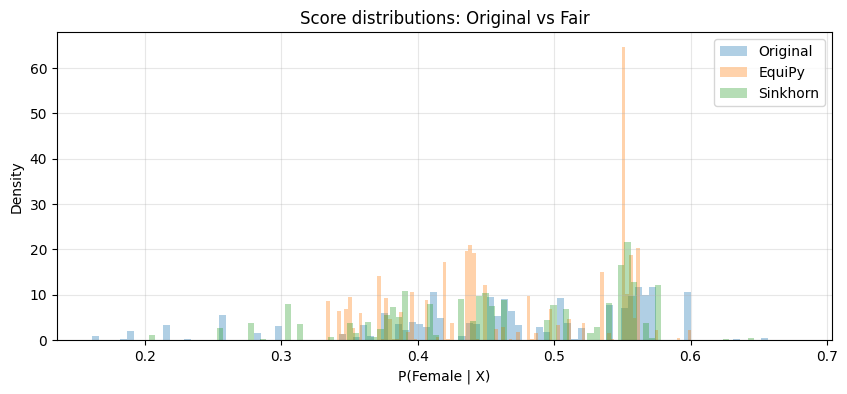

In [21]:
# Histogram comparison: original vs EquiPy vs Sinkhorn
plt.figure(figsize=(10, 4))
plt.hist(p_test, bins=100, density=True, alpha=0.35, label="Original")
plt.hist(p_test_fair_equipy, bins=100, density=True, alpha=0.35, label="EquiPy")
plt.hist(p_fair_sink, bins=100, density=True, alpha=0.35, label="Sinkhorn")
plt.xlabel("P(Female | X)")
plt.ylabel("Density")
plt.title("Score distributions: Original vs Fair")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 7. Trade-off sweep: EquiPy (epsilon) and Sinkhorn (alpha)

In [22]:
# -------------------------------------------------
# 7a. EquiPy trade-off via epsilon
#     epsilon=0 → full fairness, epsilon=1 → original
# -------------------------------------------------
eps_grid = np.linspace(0.0, 1.0, 11)

rows_equipy = []
for e in eps_grid:
    eps = [float(e)] * len(S_test.columns)
    y_fair = wasserstein.transform(
        y=p_test,
        sensitive_features=S_test,
        epsilon=eps,
    )
    ll  = log_loss(y_test, np.clip(y_fair, 1e-15, 1 - 1e-15))
    unf = unfairness(y=y_fair, sensitive_features=S_test)
    rows_equipy.append({"epsilon": e, "log_loss": ll, "unfairness": unf})

results_equipy = pd.DataFrame(rows_equipy)
print(results_equipy)

    epsilon  log_loss  unfairness
0       0.0  0.679676    0.031975
1       0.1  0.678084    0.048925
2       0.2  0.676630    0.069857
3       0.3  0.675313    0.091674
4       0.4  0.674134    0.117748
5       0.5  0.673093    0.135076
6       0.6  0.672194    0.156609
7       0.7  0.671441    0.177542
8       0.8  0.670837    0.198910
9       0.9  0.670391    0.224014
10      1.0  0.670112    0.247020


In [23]:
# -------------------------------------------------
# 7b. Sinkhorn trade-off via alpha
#     alpha=0 → full fairness, alpha=1 → original
# -------------------------------------------------
alpha_grid = np.linspace(0.0, 1.0, 11)

rows_sink = []
for a in alpha_grid:
    z_fair_a = apply_fair_maps_to_test_logits(
        p_test=z_test,
        S_test=S_test,
        grid=grid,
        maps=maps,
        alpha=a,
    )
    p_fair_a = sigmoid(z_fair_a)
    ll  = sk_log_loss_binary(y_test, p_fair_a)
    unf = unfairness(p_fair_a, S_test)
    rows_sink.append({"alpha": a, "log_loss": ll, "unfairness": unf})

results_sink = pd.DataFrame(rows_sink)
print(results_sink)

    alpha  log_loss  unfairness
0     0.0  0.672042    0.193783
1     0.1  0.671741    0.196305
2     0.2  0.671464    0.202882
3     0.3  0.671211    0.209411
4     0.4  0.670983    0.215890
5     0.5  0.670778    0.222320
6     0.6  0.670598    0.228699
7     0.7  0.670441    0.233590
8     0.8  0.670308    0.237930
9     0.9  0.670199    0.242219
10    1.0  0.670112    0.247020


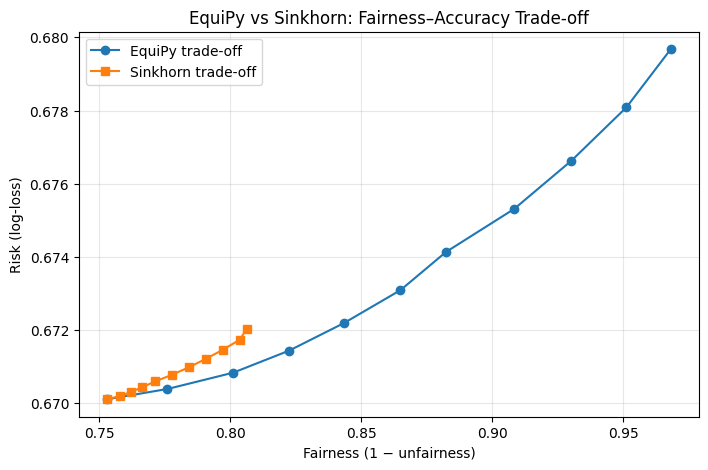

In [24]:
# -------------------------------------------------
# Plot: Fairness vs Risk trade-off (EquiPy vs Sinkhorn)
# -------------------------------------------------
plt.figure(figsize=(8, 5))
plt.plot(1 - results_equipy["unfairness"], results_equipy["log_loss"],
         marker="o", label="EquiPy trade-off")
plt.plot(1 - results_sink["unfairness"], results_sink["log_loss"],
         marker="s", label="Sinkhorn trade-off")
plt.xlabel("Fairness (1 − unfairness)")
plt.ylabel("Risk (log-loss)")
plt.title("EquiPy vs Sinkhorn: Fairness–Accuracy Trade-off")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

## 8. Visualizations: per-group score distributions

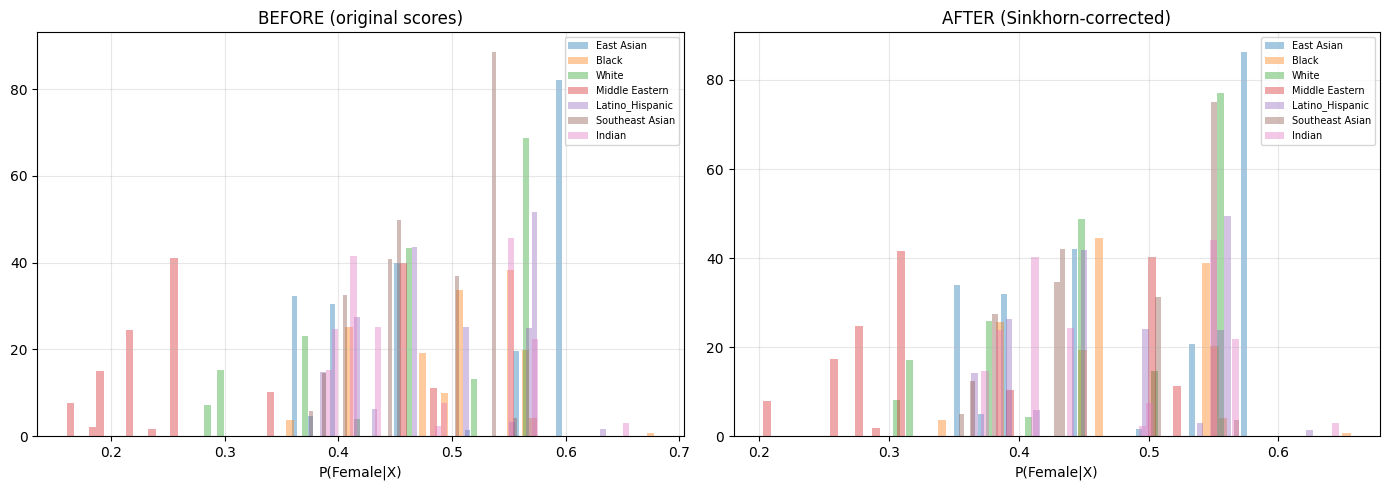

In [25]:
# Per-group histograms BEFORE and AFTER Sinkhorn correction
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for g in S_test["race_name"].unique():
    mask = (S_test["race_name"] == g).values
    axes[0].hist(p_test[mask], bins=50, density=True, alpha=0.4, label=g)
    axes[1].hist(p_fair_sink[mask], bins=50, density=True, alpha=0.4, label=g)

axes[0].set_title("BEFORE (original scores)")
axes[0].set_xlabel("P(Female|X)")
axes[0].legend(fontsize=7)
axes[0].grid(True, alpha=0.3)

axes[1].set_title("AFTER (Sinkhorn-corrected)")
axes[1].set_xlabel("P(Female|X)")
axes[1].legend(fontsize=7)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

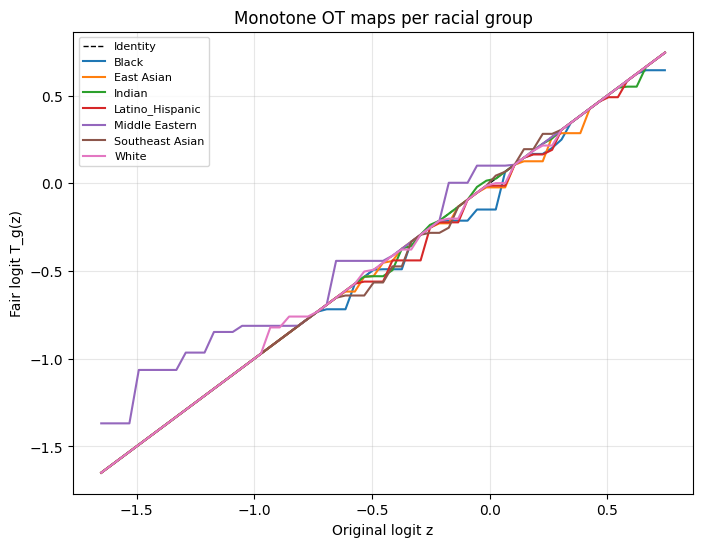

In [26]:
# Monotone transport maps T_g: logit → logit
# Points above the diagonal: group is pushed UP (model underestimated)
# Points below the diagonal: group is pushed DOWN (model overestimated)

plt.figure(figsize=(8, 6))
plt.plot(grid, grid, "k--", linewidth=1, label="Identity")

for key, T_g in maps.items():
    label = key[0] if isinstance(key, tuple) else key
    plt.plot(grid, T_g, linewidth=1.5, label=label)

plt.xlabel("Original logit z")
plt.ylabel("Fair logit T_g(z)")
plt.title("Monotone OT maps per racial group")
plt.legend(fontsize=8)
plt.grid(True, alpha=0.3)
plt.show()

## 9. Sinkhorn convergence diagnostics

In [27]:
import ot
import jax.numpy as jnp

# Re-run Sinkhorn with diagnostics to inspect convergence
grid_diag = make_grid(z_calib, n_bins=100, pad=1e-5)
marginals, weights = create_marginals(S_calib, z_calib, grid_diag)

C = ot.utils.dist(grid_diag.reshape(-1, 1), grid_diag.reshape(-1, 1))
C = C / C.max()

bary, diag = barycenter_sinkhorn(
    jnp.array(marginals),
    jnp.array(C),
    jnp.array(weights.astype(float)),
    reg=1e-2,
    tol=1e-10,
    maxiter=10_000,
    return_diagnostics=True,
)

print(f"Iterations: {int(diag['iterations'])}")
print(f"Final error: {float(diag['error']):.2e}")

Iterations: 101
Final error: 2.66e-12


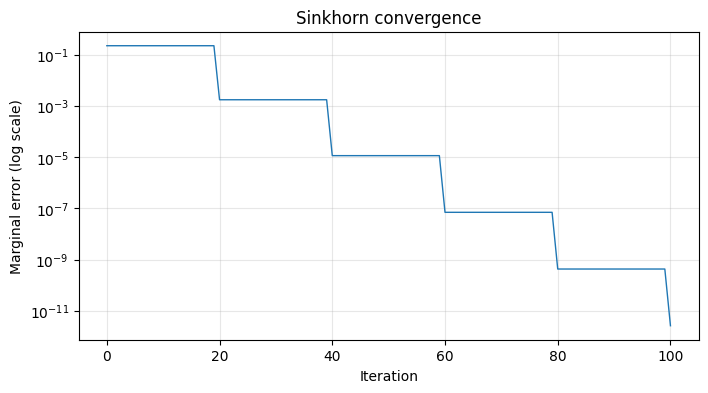

In [28]:
# Plot: convergence curve (marginal error vs iteration)
errors = np.array(diag["errors"])
valid = ~np.isnan(errors)

plt.figure(figsize=(8, 4))
plt.semilogy(np.where(valid)[0], errors[valid], linewidth=1)
plt.xlabel("Iteration")
plt.ylabel("Marginal error (log scale)")
plt.title("Sinkhorn convergence")
plt.grid(True, alpha=0.3)
plt.show()

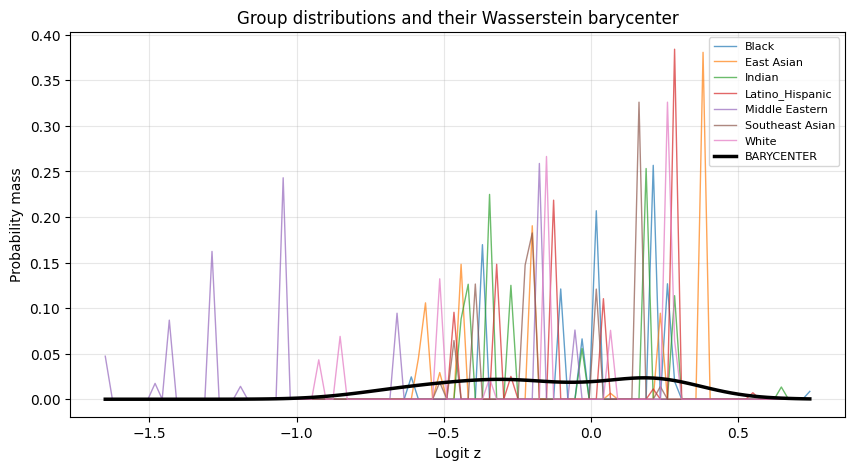

In [29]:
# Plot: group distributions vs barycenter
plt.figure(figsize=(10, 5))

masks = create_marginal_masks(S_calib)
for key, mask in masks.items():
    h = hist_on_grid(z_calib[mask], grid_diag)
    label = key[0] if isinstance(key, tuple) else key
    plt.plot(grid_diag, h, linewidth=1, alpha=0.7, label=label)

plt.plot(grid_diag, np.array(bary), "k-", linewidth=2.5, label="BARYCENTER")

plt.xlabel("Logit z")
plt.ylabel("Probability mass")
plt.title("Group distributions and their Wasserstein barycenter")
plt.legend(fontsize=8)
plt.grid(True, alpha=0.3)
plt.show()

## 10. Intersectional fairness: race × age

We can enforce DP with respect to intersectional groups (e.g., race × age).
The Sinkhorn pipeline treats every unique combination as a separate group.

**Caveat**: more groups → fewer samples per group → noisier histograms.
We collapse age into 3 coarse bins to keep group sizes reasonable.

In [30]:
# Collapse age into 3 broad groups
def coarse_age(age_code):
    if age_code <= 2:   return "young"     # 0-2, 3-9, 10-19
    elif age_code <= 5: return "adult"     # 20-29, 30-39, 40-49
    else:               return "senior"    # 50-59, 60-69, 70+

S_calib_inter = pd.DataFrame({
    "race": S_calib["race_name"],
    "age_group": df_full["age"].iloc[idx_calib].reset_index(drop=True).map(coarse_age),
})
S_test_inter = pd.DataFrame({
    "race": S_test["race_name"],
    "age_group": df_full["age"].iloc[idx_test].reset_index(drop=True).map(coarse_age),
})

n_groups = S_calib_inter.astype(str).agg("_".join, axis=1).nunique()
n_bins_i, n_min_i, _ = fast_bins_choice(S_calib_inter)
print(f"Intersectional groups: {n_groups}")
print(f"Smallest group: {n_min_i} samples → n_bins = {n_bins_i}")

Intersectional groups: 21
Smallest group: 198 samples → n_bins = 30


In [31]:
# Fit and apply intersectional Sinkhorn maps
# Note: we increase sinkhorn_reg because groups are smaller
maps_inter, grid_inter = monge_maps_fit(
    S_calib=S_calib_inter,
    p_calib=z_calib,
    sinkhorn_reg=5e-2,
    sinkhorn_tol=1e-8,
    sinkhorn_maxiter=50_000,
    pad=1e-5,
    cost='l2',
)

z_fair_inter = apply_fair_maps_to_test_logits(
    p_test=z_test, S_test=S_test_inter,
    grid=grid_inter, maps=maps_inter,
)
p_fair_inter = sigmoid(z_fair_inter)

print(f"\n{'Setting':<30} {'Log-Loss':>10} {'Unfairness':>12}")
print("-" * 55)
print(f"{'Original':<30} {sk_log_loss_binary(y_test, p_test):>10.4f} {unfairness(p_test, S_test):>12.4f}")
print(f"{'Sinkhorn (race only)':<30} {sk_log_loss_binary(y_test, p_fair_sink):>10.4f} {unfairness(p_fair_sink, S_test):>12.4f}")
print(f"{'Sinkhorn (race × age)':<30} {sk_log_loss_binary(y_test, p_fair_inter):>10.4f} {unfairness(p_fair_inter, S_test_inter):>12.4f}")


Setting                          Log-Loss   Unfairness
-------------------------------------------------------
Original                           0.6701       0.2470
Sinkhorn (race only)               0.6720       0.1938
Sinkhorn (race × age)              0.6735       0.2963


Explicando os resultados com as minhas palavras

Você treinou um modelo pra prever gênero a partir de dados de rosto. Ele funciona, mas funciona de forma desigual dependendo da raça da pessoa. Pra pessoas brancas ou do leste asiático, o modelo dá scores altos e confiantes.

Pra pessoas do Oriente Médio, ele dá scores bem mais baixos. Ou seja, o modelo não trata todo mundo com o mesmo critério e isso é viés.

Aí entra o transporte ótimo. A ideia é: imagina que cada grupo racial tem uma "pilha" de scores com um formato diferente. O que a gente faz é calcular uma pilha intermediária, o baricentro e empurrar todas as pilhas pra ficarem com esse formato.

É como nivelar o campo. Depois dessa correção, se alguém te der um score, você não consegue mais adivinhar a raça da pessoa. Isso é Demographic Parity.

A gente testou dois métodos pra fazer isso. O EquiPy faz a correção exata e praticamente zera o viés, mas perde um pouquinho de acurácia. O Sinkhorn faz uma versão suavizada corrige menos, mas é mais estável e flexível.

Os dois mostram a mesma coisa: dá pra tirar boa parte do viés pagando quase nada em performance, o que sugere que a "acurácia" do modelo original vinha em parte de explorar diferenças raciais.

O gráfico mais importante é a curva de trade-off: ela mostra que fairness e acurácia não são opostos absolutos. Nesse dataset, o custo de ser justo é menor que 1%. E o mapa de transporte mostra quem precisa de mais correção Middle Eastern é o grupo mais afetado, o que levanta questões sobre que padrões o modelo aprendeu.

---

## Questions for discussion with the professor and TAs

### Theoretical questions

**Q1. Wasserstein barycenter uniqueness.**
Chzhen et al. (2020) show that the optimal DP-fair predictor for regression
is obtained by mapping each group's distribution to the Wasserstein-2 barycenter.
For 1-D continuous distributions with quadratic cost, the barycenter is unique
and given by $F_{\bar\mu}^{-1}(t) = \sum_g \lambda_g F_{\mu_g}^{-1}(t)$.
Is uniqueness still guaranteed when we discretize onto a grid?
What about under entropic regularization—does the regularized barycenter converge
to the exact one as $\varepsilon \to 0$?

**Q2. From regression to classification.**
The barycenter-based post-processing was originally derived for regression under
squared loss. Xian et al. (2023) extend this to classification, but the optimality
characterization is more involved (it requires randomized classifiers at the
boundary). In our notebook we apply the same pipeline to binary probabilities
via logits. What theoretical guarantees do we lose by doing this?
Is the logit transform just a practical heuristic, or does it have a
deeper justification (e.g., relating to the KL divergence or log-loss)?

**Q3. Choice of cost function.**
We use $c(x,y) = |x - y|^2$ (Wasserstein-2). The code also supports
$c(x,y) = |x - y|$ (Wasserstein-1). How does the choice of cost affect:
- The shape of the barycenter?
- The monotonicity and smoothness of the transport maps?
- The convergence behavior of Sinkhorn?
Is there a principled way to choose between them for the fairness application?

**Q4. Entropic regularization and blurring.**
Larger $\varepsilon$ makes Sinkhorn converge faster but "blurs" the barycenter.
The regularized Wasserstein distance satisfies
$W_\varepsilon(\mu, \nu) \leq W(\mu, \nu) + \varepsilon \log n$.
How does this blurring interact with the fairness guarantee?
Specifically, if we use a large $\varepsilon$, do the corrected distributions
still satisfy approximate DP, and can we bound the approximation error?

**Q5. Barycenter weights $\lambda_g$.**
In our code, `weights` is set proportional to group sizes: $\lambda_g \propto n_g$.
This means larger groups "pull" the barycenter toward them.
What happens if we set $\lambda_g = 1/G$ (uniform) instead?
The Le Gouic et al. (2020) projection result uses the population proportions—
is there a theoretical optimality argument for $\lambda_g = n_g / n$
vs $\lambda_g = 1/G$?

### Algorithmic questions

**Q6. Log-domain Sinkhorn stability.**
The implementation uses log-domain computations throughout
(i.e., $\ln u$, $\ln v$, $\ln K$) to avoid numerical underflow.
Are there cases where even log-domain Sinkhorn can fail
(e.g., very small $\varepsilon$, very unbalanced marginals)?
Would approaches like $\varepsilon$-scaling or simulated annealing help?

**Q7. Isotonic regression for monotonicity.**
After computing the barycentric projection $T_g(x) = \sum_j \pi_g(x,j) y_j / \mu_g(x)$,
we enforce monotonicity via isotonic regression. Why isn't the raw projection
already monotone? Under what conditions on $\pi_g$ would it be?
What does breaking monotonicity imply for the within-group ranking of individuals?

**Q8. Grid discretization error.**
All computations happen on a finite grid of $m$ bins.
What is the approximation error introduced by this discretization?
Is there a known rate $O(1/m)$ or $O(1/m^2)$ for the Wasserstein distance
between the continuous and discretized barycenters?
How does `fast_bins_choice` interact with this—should we just use as many bins
as possible, or is there a bias-variance trade-off?

### Fairness and methodology questions

**Q9. EquiPy vs Sinkhorn: when does each approach win?**
EquiPy uses exact 1-D OT (quantile matching) applied sequentially per attribute.
Our Sinkhorn pipeline discretizes and solves a regularized barycenter problem
over the full intersectional groups. Under what conditions would we expect
one to outperform the other in terms of fairness, risk, or computational cost?
Does sequential fairness (attribute by attribute) lose any theoretical
guarantees compared to joint fairness?

**Q10. Post-processing vs in-processing.**
The entire pipeline is post-processing: we fix the base model and only transform
its outputs. Le Gouic et al. show this is a projection to the closest fair
predictor in L2. But is this always the best we can do?
Could in-processing methods (fairness constraints during training) achieve
a better fairness-accuracy trade-off, and if so, under what conditions?

**Q11. Unseen groups at test time.**
The code uses `unseen='identity'` for test groups not present in calibration
(i.e., their scores are left unchanged). Is there a better strategy?
For example, could we assign them to the nearest group's map, or use
the barycenter distribution directly? What are the fairness implications?

**Q12. Connection to Monge maps.**
In 1-D with quadratic cost, the optimal transport map is
$T = F_\nu^{-1} \circ F_\mu$, i.e., quantile-to-quantile.
How does this relate to what `barycentric_projection_from_log_scalings_stable`
computes? In the exact (unregularized) case, does our pipeline recover the
Monge map, or is there always an approximation due to the grid and
regularization?

**Q13. Multi-dimensional extension.**
Our pipeline is strictly 1-D (scalar scores). If we had multi-dimensional
outputs (e.g., multi-class probabilities, or embedding vectors),
the 1-D Sinkhorn barycenter no longer applies directly.
What are the main challenges for extending this to $d > 1$?
Would sliced Wasserstein barycenters be a viable alternative?

**Q14. Sensitivity of the trade-off parameter.**
The trade-off is controlled by $\alpha$ (Sinkhorn) or $\varepsilon$ (EquiPy),
interpolating between the fair and original predictions.
Is there a principled way to choose the operating point
(e.g., a constrained optimization formulation, a regulatory threshold)?
How stable is the trade-off curve to changes in the calibration set?